# Fuzzy Clustering with Anomalous Patterns

> a) Study the fuzzy c-means (FCM) program in the software package of your choice1.
Apply the program to your dataset at the same hyperparameter c with random seeds. Do this for several different values c= c_min, ..., c_max. Plot the FCM clustering criterion (FCM cost function) in function of c. Analyse the graphic and comment if any number of clusters better fits your data than the others.
Hint: If, at a given c, the fuzzy c-means converges to the same result at any initialization, then it is likely that parameter c is correct.

As we are working with Python we chose to study and work with `skfuzzy 0.2` which offers the FCM algorithm as `skfuzzy.cmeans(data, c, m, error, maxiter, init=None, seed=None)` implemented according to Ross et al. [1]

[1] Ross, Timothy J. Fuzzy Logic With Engineering Applications, 3rd ed.
           Wiley. 2010. ISBN 978-0-470-74376-8 pp 352-353, eq 10.28 - 10.35.

In [1]:
import skfuzzy as fuzz
import pandas as pd

data = pd.read_csv('./communities_processed.csv')

data = data.drop('ViolentCrimesPerPop', axis = 1)
data

,population,householdsize,agePct12t29,agePct65up,medFamInc,PctPopUnderPov,MedRentPctHousInc,TotalPctDiv,PctLargHouseFam,pctUrban,PctHousOccup
0,11980,3.10,21.44,11.33,79584,1.96,316,4.47,4.81,100.00,98.37
1,23123,2.82,21.30,17.18,55323,3.98,205,5.42,4.25,100.00,97.15
2,29344,2.43,25.88,10.28,42112,4.75,150,12.55,2.97,100.00,95.68
3,16656,2.40,25.20,17.57,26501,17.23,114,12.91,3.93,0.00,91.19
4,11245,2.76,40.53,12.65,24018,29.99,160,9.73,5.23,0.00,92.45
...,...,...,...,...,...,...,...,...,...,...,...
2210,56216,3.07,30.16,8.08,27388,25.06,157,13.34,13.49,100.00,96.40
2211,12251,2.68,31.23,12.57,25000,20.79,121,13.77,5.03,100.00,89.72
2212,32824,2.46,20.96,20.73,34973,7.56,204,11.23,5.10,100.00,93.30
2213,13547,2.89,30.01,10.42,22103,30.32,182,12.48,9.83,0.00,85.39


`skfuzzy.cmeans()` provides the following interface:

```
Parameters
    ----------
    data : 2d array, size (S, N)
        Data to be clustered.  N is the number of data sets; S is the number
        of features within each sample vector.
    c : int
        Desired number of clusters or classes.
    m : float
        Array exponentiation applied to the membership function u_old at each
        iteration, where U_new = u_old ** m.
    error : float
        Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error.
    maxiter : int
        Maximum number of iterations allowed.
    init : 2d array, size (S, N)
        Initial fuzzy c-partitioned matrix. If none provided, algorithm is
        randomly initialized.
    seed : int
        If provided, sets random seed of init. No effect if init is
        provided. Mainly for debug/testing purposes.

    Returns
    -------
    cntr : 2d array, size (S, c)
        Cluster centers.  Data for each center along each feature provided
        for every cluster (of the `c` requested clusters).
    u : 2d array, (S, N)
        Final fuzzy c-partitioned matrix.
    u0 : 2d array, (S, N)
        Initial guess at fuzzy c-partitioned matrix (either provided init or
        random guess used if init was not provided).
    d : 2d array, (S, N)
        Final Euclidian distance matrix.
    jm : 1d array, length P
        Objective function history.
    p : int
        Number of iterations run.
    fpc : float
        Final fuzzy partition coefficient.

```

We evaluated the hyperparameter `c` defining the number of desired clusters on a range from `c_min` = 2, 3, 4 ... to `c_max` = 22. The `c_max` parameter stems from the fact that we have 2215 datapoints in total and assume that meaningful clusters for our dataset of communitites should at least have size 10 to keep them interpretable.

According to Ross et al. [1] p. 354 and our classes so far research has not concluded on a theoretical optimum for parameter `m`. However, setting `m` to a value between 1.25 - 2, and especially setting `m` to 2 seems to provide good results. 
For our project we chose to set `m` to 2.

The `error` parameter sets the threshold for the stopping criterion by convergence. If the difference between the clustering criterion between to iterations sinks below the specified threshold, calculations are stopped. We followed the example from Ross et al. and set the error to `0.01`.

The `maxiter` parameter defines the second stopping criterion by number of iterations. If no convergence of the error could be reached, the calculation stopps after the set maximum number of iterations. As we preferred to reach a solution with a convergence stopping criterion we set the `maxiter` parameter to the high value of 100. 
#TODO: Track how many iterations it actually took.

As the implementation already starts with random seeds if no `init` matrix is specified we did not have to specifiy random seeds on our own.

As first tests with different `c` parameters set to 2, 4, 10 and 20, showed that for all `c` the variation within the objective function convergence value was quite big, we decided to run the simulation 1000 times for each `c` to us the law of big numbers to obtain better results.

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

import itertools

def plot_distributions(df, n_plots, n_cols):
    n_rows = math.ceil(n_plots / n_cols)
    subplot_indices = list(itertools.product(range(1, n_rows + 1), range(1, n_cols + 1)))

    fig = make_subplots(rows=n_rows, cols=n_cols, start_cell="top-left")

    for index, feature in zip(range(0, n_plots), df):
        fig.add_trace(go.Histogram(x = df[feature],  name=feature), row = subplot_indices[index][0], col= subplot_indices[index][1])
        
    fig.show()


In [2]:
from collections import defaultdict

def calc_fuzzy_c_means(data, c_params, initial_prototypes=None):
    objective_function_data = defaultdict(list)
    
    m = 2
    error = 0.01
    maxiter = 100
    runs = 100

    objective_function_index = 4

    for c in c_params:
        for i in range(1, runs + 1):
            c_means_result = fuzz.cmeans(data, c, m, error, maxiter, init=initial_prototypes)
            # append the last objective function value / the value where the function converged
            objective_function_data[c].append(c_means_result[objective_function_index][-1])
    return pd.DataFrame(objective_function_data)

def calc_fuzzy_c_means_anom(data, c_param, initial_prototypes=None):
    results = []
    m = 2
    error = 0.001
    maxiter = 100
    runs = 1000
    
    res = fuzz.cmeans(data, c_param, m, error, maxiter, init=initial_prototypes)
    return res    

In [ ]:
c_params = [2, 3, 4, 5]
objective_function_data_unnormalized = calc_fuzzy_c_means(data, c_params, None)

In [ ]:
print(objective_function_data_unnormalized)
print(objective_function_data_unnormalized.std())

In [ ]:
print(objective_function_data_unnormalized.min())
print(objective_function_data_unnormalized.max())

In [ ]:
plot_distributions(objective_function_data_unnormalized, len(c_params), 3)

Apparently there is a huge variation for the convergence value of the objective value for all investigated `c` values if the data is not normalized.

In [3]:
# range normalization because we cannot make normal distribution assumption
data_norm = (data - data.min()) / (data.max() - data.min())

In [ ]:
objective_function_data_normalized = calc_fuzzy_c_means(data_norm, c_params)

In [ ]:
plot_distributions(objective_function_data_normalized, len(c_params), 3)

But while normalized data performed much better (as is logical for c fuzzy means because of the otherwise differing variations and therefore differing impacts), still no real convergences to identical values observable anywhere. Perhaps best for `c` == 3 where we only have a few weird outliers close to 0. 

In [ ]:
objective_function_data_normalized.mean()

In [ ]:
import plotly.express as px
fig = px.scatter(x = c_params, y = objective_function_data_normalized.mean())
fig.show()

In [ ]:
fig = px.scatter(x = c_params, y = objective_function_data_normalized.std())
fig.show()

`HK=(WK/WK+1 −1)(N−K−1)` should we evaluate Hartigans index?

- Visualize on the Principial Component Plane

> b) Study the (Iterative) Anomalous Pattern (IAP) clustering algorithm. Test the implementation with the benchmark data sets provided to you.

IAP clustering algorithm is an approach used to deal with the main challenges of the K-Means algorithm: specifiying the number of clusters and starting centroids a priori.

In [5]:
import pandas as pd
import numpy as np
from anomalous_adapted import anomPattern #code provided by professor


town_dataframe = pd.read_fwf('./tons.dat', names = ['POP_RES', 'PSchools', 'Doctors', 'Hospitals', 'Banks', 'Superstores', 'Petrol', 'DIY', 'Swimming', 'PostOffice', 'CABs', 'FarmMarket']) 
res = anomPattern(normalization=0,threshold=2,dataframe=town_dataframe)

/home/moritz/Uni/Portugal/PAD/pad_python/analyses/anomalous_adapted.py:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ancl = np.asarray(ancl)
/home/moritz/Uni/Portugal/PAD/pad_python/analyses/anomalous_adapted.py:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ancl = np.asarray(ancl)


> c) Take the Anomalous Clustering as the initialization algorithm to the fuzzy c-means and apply the Anomalous Patterns_FCM to your data set. Discuss the option taken for setting its stop condition. Present and visualize the found fuzzy partitions of AP-FCM taking advantage of the PCA visualization (check PCA tutorial).

/home/moritz/Uni/Portugal/PAD/pad_python/analyses/anomalous_adapted.py:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ancl = np.asarray(ancl)


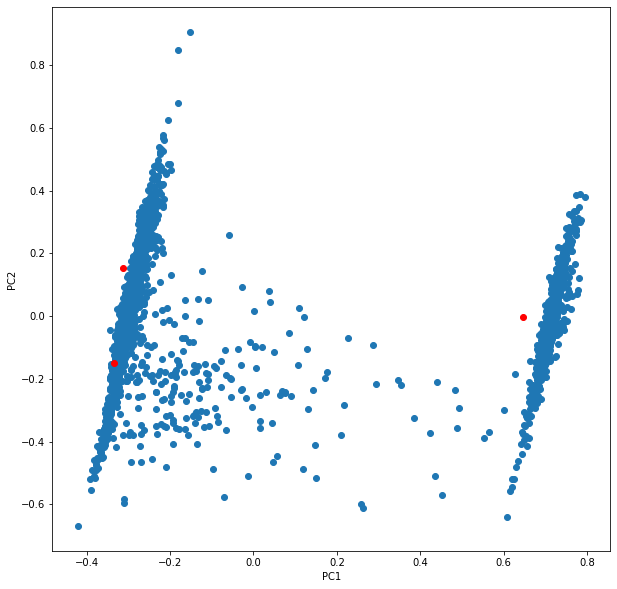

In [19]:
#TODO: plot cluster result for multiple threshold, plus benchmarks as quantitative 

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def apply_AP_FCM(threshold, data):
    #apply anomalous pattern algorithm to find start configuration
    anom_res = anomPattern(normalization=0, threshold=threshold, dataframe=data)
    #apply fuzzy-c-means
    return calc_fuzzy_c_means_anom(data.transpose(), anom_res[0], anom_res[2].transpose())

def apply_PCA(n_comp, data):
    principal=PCA(n_components=2)
    principal.fit(data)
    x = principal.transform(data)
    return x

#gm = [np.mean(principalDf[0]), np.mean(principalDf[1])]

res_50 = apply_AP_FCM(50, data_norm)

#perform PCA on result
pca_res = apply_PCA(2, data_norm)

#perform PCA on cluster centers
pca_cc = apply_PCA(2, res_50[0])

fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(111)
#x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(pca_res[:, 0], pca_res[:, 1], cmap='crest')
axis.scatter(pca_cc[:, 0], pca_cc[:, 1], c='red', cmap='hot')

axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)

plt.show()


> d) Discuss the results obtained by Anomalous Patterns FCM for your data case respecting the following: (i) location of the initial prototypes; (ii) number of clusters.

ii) We see that we either have 4 cluster, 3 or 2 depending on the threshold of the AP algorithm. If we choose a threshold higher than 100, we only get 2 clusters lying almost on the same point when projected to two principal components.

> e) Apply, at least, two validation indices, like the Adjust Rand Index (ARI) and Xie-Beni, to access the quality of the fuzzy c-partitions obtained in a). Compare these results with the one of Anomalous Patterns FCM getting in c).

In [14]:
import scipy.spatial

def pairwise_squared_distances(A, B):
    return scipy.spatial.distance.cdist(A, B)**2

def xb(x, u, v, m):
    n = x.shape[0]
    c = v.shape[0]

    um = u**m

    d2 = pairwise_squared_distances(x, v)
    v2 = pairwise_squared_distances(v, v)

    v2[v2 == 0.0] = np.inf

    return np.sum(um.T*d2)/(n*np.min(v2))

def partition_coefficient(u, x):
    n = x.shape[0]
    return np.sum(u**2 / n)
    
threshold_values = [2,3,4,5,6,7,8,9,10,20,50,80,100]
xb_values = []
pc_values = []

for threshold in threshold_values:
    cluster_res = apply_AP_FCM(threshold, data_norm)
    print('Indices for threshold value: ', threshold)
    xb_index = xb(data_norm, cluster_res[1], cluster_res[0], 2)
    pc_index = partition_coefficient(cluster_res[1], data_norm)
    xb_values.append(xb_index)
    pc_values.append(pc_values)
    print('Amount of Clusters:', len(cluster_res[0]))
    print('Xie-Beni:', xb_index)
    print('PC:', pc_index)


Indices for threshold value:  2
Amount of Clusters: 5
Xie-Beni: 1.0985984646592601
PC: 0.3996221652646219
Indices for threshold value:  3
Amount of Clusters: 5
Xie-Beni: 1.0985984646592601
PC: 0.3996221652646219
Indices for threshold value:  4
Amount of Clusters: 4
Xie-Beni: 1.4502379856419
PC: 0.5283184088462649
Indices for threshold value:  5
Amount of Clusters: 4
Xie-Beni: 1.4502379856419
PC: 0.5283184088462649
Indices for threshold value:  6
Amount of Clusters: 4
Xie-Beni: 1.4502379856419
PC: 0.5283184088462649
Indices for threshold value:  7
Amount of Clusters: 4
Xie-Beni: 1.4502379856419
PC: 0.5283184088462649
Indices for threshold value:  8
Amount of Clusters: 4
Xie-Beni: 1.4502379856419
PC: 0.5283184088462649
Indices for threshold value:  9
Amount of Clusters: 4
Xie-Beni: 1.4502379856419
PC: 0.5283184088462649
Indices for threshold value:  10
Amount of Clusters: 4
Xie-Beni: 1.4502379856419
PC: 0.5283184088462649
Indices for threshold value:  20
Amount of Clusters: 4
Xie-Beni: 1

In order to examine the amount of clusters in a quantitative way, we calculated the Xie-Beni Index and the Partition Coefficient to clustering results for multiple threshold values. The threshold values have a direct influence on the amount of clusters found by the Anomalous Pattern Algorithm. We see, that the amount of found clusters lie between 2 for low threshold values and 5 for large threshold values. Furthermore, we observe equal index values for the same amount of clusters regardless the threshold. The lowest parition coefficient has been calculated for a c = 5 while we found the lowest Xie-Beni Index value for a cluster size of 3. Interestingly, the Xie-Beni Index value increases extremely if c = 2. We consider partitions with less clusters better, the smaller the differences between the values of a validation index are. As there is a huge difference between c = 2 and c = 3 regarding the Xie-Beni index, we consider the cluster amount of 3 as best. This finding coincides with the one we made in section... where we also argued in favor for an amount of 3 clusters.

> f) Make interpretation of the found clusters (after defuzzification) for your data, as discussed in the classes.

Text(0, 0.5, 'PC2')

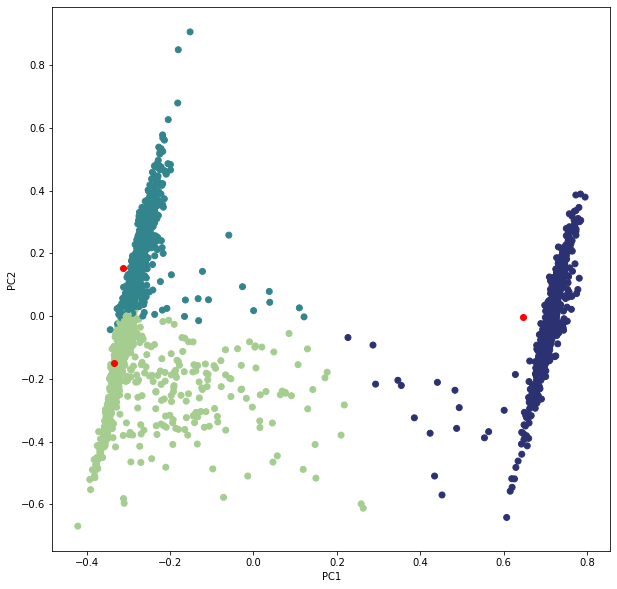

In [20]:
#Defuzzification
cluster_id = []
row_index = 0
for row in res_50[1].transpose():
    cluster_id.append(list(row).index(np.max(row)))

principalDf = pd.DataFrame(data = pca_res)
principalDf['cluster'] = cluster_id

fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(111)
#x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(pca_res[:, 0], pca_res[:, 1], c=principalDf.cluster, cmap='crest')
axis.scatter(pca_cc[:, 0], pca_cc[:, 1], c='red', cmap='hot')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)